# PART 3 : PCA ANALYSIS 

In [25]:
from sklearn.decomposition import PCA
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
import os

In [26]:
output_dir_func = 'sub_control01_preprocessed/func'
data_path = os.path.join(output_dir_func, 'concatenated_standardized_mc_smoothed.nii.gz')
img = nib.load(data_path)
affine = img.affine
data = np.asanyarray(img.dataobj)

# need a 4D image
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
data.shape

(80, 80, 50, 315)

In [27]:
# voxels = features 
slice_non_background = data[:,:,:,0] != 0
# Vectorize : Taking only non-zero voxels into a vector 

# normalize
samples = data[slice_non_background]
spatial_means = np.mean(samples, axis=1)
row_means = np.outer(spatial_means, np.ones(n_vols))
X = samples - row_means

# quality check
assert np.abs(X.mean(axis=-1)).max() < 1e-5

# must be 2D image flatten x nb of volums
X.shape

(320000, 315)

In [28]:
# PCA 
nb_components = 80 

# YOUR CODE HERE 
pca = PCA(n_components=nb_components)
pca.fit(X.T) 

PCA(n_components=80)

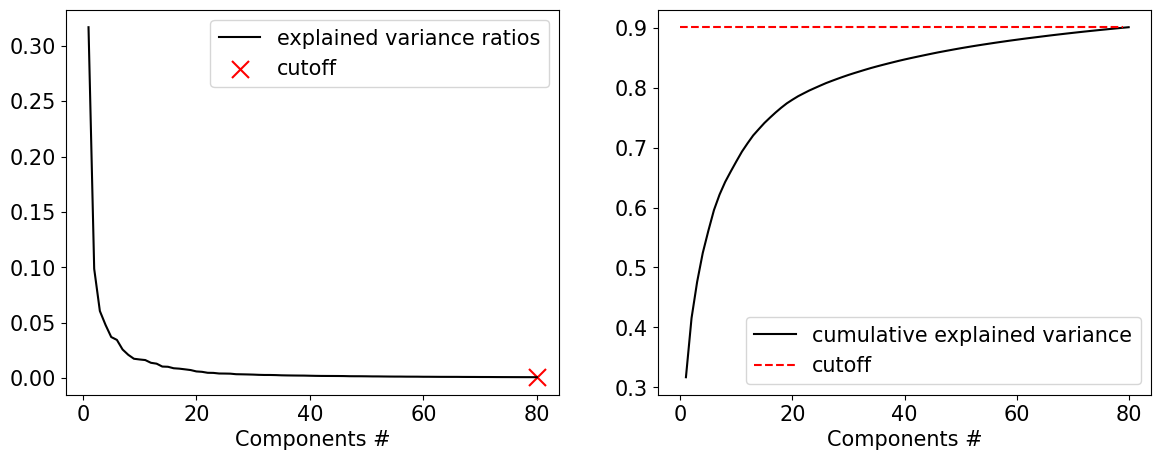

In [29]:
# Plot 

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)

nb_clusters = nb_components 

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

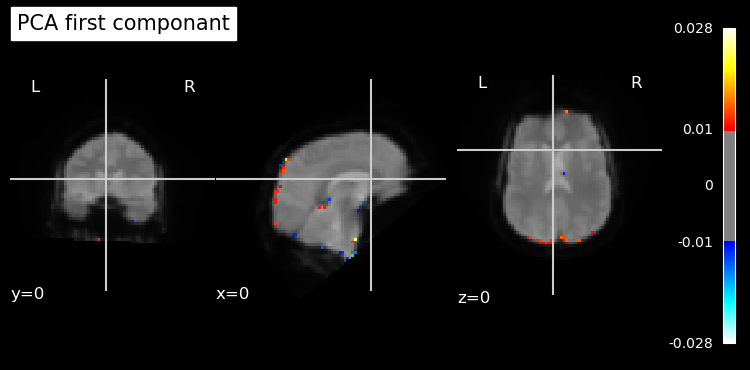

In [30]:
# Bring back to the right space

pca_clusters = []
for cluster_idx in range(nb_clusters):
    pca_component = np.zeros(vol_shape)
    pca_component[slice_non_background] = pca.components_[cluster_idx]
    pca_clusters.append(pca_component)


mean_img_ = mean_img(img)
pca_out = nib.Nifti1Image(pca_clusters[0], affine)


plot_stat_map(pca_out, bg_img=mean_img_, 
              threshold=0.01,
              cut_coords=[0,0,0],
              black_bg=True,
              title=f'PCA first componant')

folder_pca_path = 'derivatives/PCA'

if not os.path.exists(folder_pca_path):
    os.makedirs(folder_pca_path)

nib.save(pca_out, os.path.join(folder_pca_path, 'PCA_componant0_thr01'))

